In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.ndimage.filters import gaussian_filter

def initialize_phi(image_shape, type='checkerboard'):
    if type == 'checkerboard':
        phi = np.array([[(-1)**(i+j) for j in range(image_shape[1])] for i in range(image_shape[0])])
    elif type == 'circle':
        center = (image_shape[0] // 2, image_shape[1] // 2)
        radius = min(center)
        phi = np.array([[radius - np.sqrt((i-center[0])**2 + (j-center[1])**2) for j in range(image_shape[1])] for i in range(image_shape[0])])
    return phi

def reinitialize_phi(phi, iterations=10):
    binary_mask = (phi <= 0).astype(np.int32)
    positive_distance = distance_transform_edt(binary_mask)
    negative_distance = distance_transform_edt(1 - binary_mask)
    signed_distance = positive_distance - negative_distance
    for _ in range(iterations):
        signed_distance = gaussian_filter(signed_distance, sigma=1)
    return signed_distance

def chan_vese_evolution(image, phi, lambda1, lambda2, mu, nu, dt, num_iterations):
    for iteration in range(num_iterations):
        c1 = np.mean(image[phi <= 0])
        c2 = np.mean(image[phi > 0])
        force = mu * (4*image - 2*c1 - 2*c2) - nu
        phi = phi + dt * force
        if iteration % 50 == 0:
            phi = reinitialize_phi(phi)
    return phi

def extract_segmentation(phi):
    return np.where(phi <= 0, 1, 0)


/var/folders/lv/dz4h_s412yg9zb37kn7v1r580000gn/T/ipykernel_1801/1092575827.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


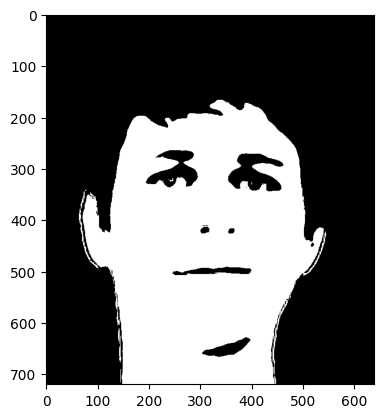

In [2]:
# Load your image here
image = plt.imread("/Users/dianatat/Downloads/Screenshot 2023-10-29 at 00.42.02.png")[:,:,0]  # Assuming a grayscale image or converting it to grayscale

phi = initialize_phi(image.shape, type='checkerboard')
phi = chan_vese_evolution(image, phi, lambda1=1, lambda2=1, mu=0.5, nu=0, dt=0.1, num_iterations=100)
segmentation = extract_segmentation(phi)

# Display the segmentation
plt.imshow(segmentation, cmap='gray')
plt.show()


In [6]:
import cv2
import numpy as np
import sol_chanvese_test
import matplotlib.pyplot as plt

# Load your image here
image = plt.imread("/Users/dianatat/Downloads/Screenshot 2023-10-29 at 00.42.02.png")[:, :, 0]  # Assuming a grayscale image or converting it to grayscale

# Initialize phi as an array with the same shape as the image
phi = np.zeros_like(image, dtype=np.float32)

mu = 0.5
nu = 0
eta = 1  # Adjust as needed
lambda1 = 1
lambda2 = 1
tol = 1e-5  # Adjust as needed
epHeaviside = 1e-5  # Adjust as needed
dt = 0.1
iterMax = 100
reIni = 0  # Set to 0 if you don't want reinitialization

phi = initialize_phi(image.shape, type='checkerboard')
phi = sol_chanvese_test.sol_ChanVeseIpol_GDExp(image, phi, lambda1=1, lambda2=1, mu=0.5, nu=0, dt=0.1, num_iterations=100)
segmentation = extract_segmentation(phi)

# Display the segmentation
plt.imshow(segmentation, cmap='gray')
plt.show()

# resulting_phi = sol_chanvese_test.sol_ChanVeseIpol_GDExp(image, phi, mu, nu, eta, lambda1, lambda2, tol, epHeaviside, dt, iterMax, reIni)


# # Extract the segmentation
# segmentation = extract_segmentation(resulting_phi)



TypeError: initialize_phi() got an unexpected keyword argument 'type'

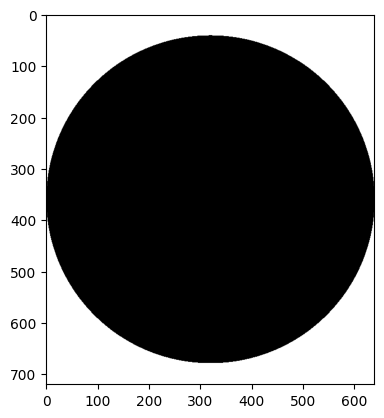

In [5]:

image = plt.imread("/Users/dianatat/Downloads/Screenshot 2023-10-29 at 00.42.02.png")[:,:,0]  # Assuming a grayscale image or converting it to grayscale



# Define initial phi using a circle initialization
def initialize_phi(image_shape):
    center = (image_shape[0] // 2, image_shape[1] // 2)
    radius = min(center)
    phi = np.array([[radius - np.sqrt((i-center[0])**2 + (j-center[1])**2) for j in range(image_shape[1])] for i in range(image_shape[0])])
    return phi

phi = initialize_phi(image.shape)

# Chan-Vese segmentation parameters
lambda1 = 1.0
lambda2 = 1.0
mu = 0.1
nu = 0
dt = 0.1
num_iterations = 1000
epsilon = 1e-3

def dirac_delta(x, epsilon):
    return (1.0 / np.pi) * (epsilon / (x**2 + epsilon**2))

def curvature(phi):
    fy, fx = np.gradient(phi)
    norm = np.sqrt(fx**2 + fy**2)
    Nx = fx / (norm + 1e-8)
    Ny = fy / (norm + 1e-8)
    Nyy, Nxx = np.gradient(Ny)
    Nxy, Nyx = np.gradient(Nx)
    div = Nxx + Nyy
    return div

stopping_threshold = 0.25

for i in range(num_iterations):
    old_phi = phi.copy()

    # Update c1 and c2
    c1 = np.mean(image[phi <= 0])
    c2 = np.mean(image[phi > 0])

    delta_phi = dirac_delta(phi, epsilon)
    F = lambda1 * (image - c1)**2 - lambda2 * (image - c2)**2
    div = curvature(phi)

    # Update phi using Chan-Vese equation
    phi = phi + dt * (mu * div - nu - F * delta_phi)

    # Stopping criteria
    if np.max(np.abs(phi - old_phi)) < stopping_threshold:
        break

# Extract the final segmentation
segmentation = np.where(phi <= 0, 1, 0)

# Visualize the segmentation result
plt.imshow(segmentation, cmap="gray")
plt.show()
